In [2]:
using Sundials
using Random, Plots
using Plots.PlotMeasures
using Zygote, ForwardDiff
using OrdinaryDiffEq, DiffEqSensitivity
using LinearAlgebra
using Statistics
using ProgressBars, Printf
using Flux
using Flux.Optimise: update!
using Flux.Losses: mae, mse
using BSON: @save, @load
using DelimitedFiles
using YAML

In [148]:
ns = 5;

#alg = Tsit5();
#alg = TRBDF2();
alg = CVODE_BDF();
#const R = -1/8.314  # universal gas constant, J/mol*K
const R = -1.0 / 8.314e-3  # universal gas constant, kJ/mol*K 

T0 = 500  #Kelvin
beta = 5

lb = 1e-8
llb = lb

1.0e-8

In [149]:
### 5s4r reaction mechanism without catalytic species

A = [20.83, 13.13, 15.36, 22.43]; 
Ea = [133.27, 189.78, 157.62, 148.6];
b = [0.26, 0, 0.13, 0.33];

function crnn!(du, u, p, t)
    T = T0 .+ beta * t/60
    u_ = clamp.(u, lb, 10.0)

    r1 = exp(A[1] + b[1]*log(T) + Ea[1] * R/T) * u_[1]^0.72
    r2 = exp(A[2] + b[2]*log(T) + Ea[2] * R/T) * u_[4]^0.24
    r3 = exp(A[3] + b[3]*log(T) + Ea[3] * R/T) * u_[2]^0.08 * u_[3]^0.06
    r4 = exp(A[4] + b[4]*log(T) + Ea[4] * R/T) * u_[4]^0.68

    du[1] = -0.72 * r1;
    du[2] = 0.053 * r2 - 0.08 * r3;
    du[3] = 0.08 * r2 - 0.06 * r3 + 0.05 * r4;
    du[4] = 0.58 * r1 - 0.24 * r2 + 0.15 * r3 - 0.68 * r4;
    du[5] = 0.15 * r1 + 0.10 * r2 + 0.61 * r4; 
end

crnn! (generic function with 1 method)

In [151]:
### 5s4r-03 reaction mechanism without catalytic species

A = [25.99, 25.85, 18.06, 15.66]; 
Ea = [163.88, 154.03, 157.31, 214.43];
b = [0.33, 0.34, 0.1, 0.0];

function crnn!(du, u, p, t)
    
    T = T0 .+ beta * t/60
    u_ = clamp.(u, lb, 10.0)

    r1 = exp(A[1] + b[1]*log(T) + Ea[1] * R/T) * u_[1]^0.80
    r2 = exp(A[2] + b[2]*log(T) + Ea[2] * R/T) * u_[4]^0.85
    r3 = exp(A[3] + b[3]*log(T) + Ea[3] * R/T) * u_[2]^0.29 * u_[3]^0.04
    r4 = exp(A[4] + b[4]*log(T) + Ea[4] * R/T) * u_[4]^0.25

    du[1] = -0.80 * r1;
    du[2] = 0.03 * r2 - 0.29 * r3 + 0.1 * r4;
    du[3] = 0.05 * r2 - 0.04 * r3 + 0.07 * r4;
    du[4] = 0.62 * r1 - 0.85 * r2 + 0.33 * r3 - 0.25 * r4;
    du[5] = 0.18 * r1 + 0.77 * r2 + 0.08 * r4; 
end

crnn! (generic function with 1 method)

In [5]:
### 4s4r reaction mechanism without catalytic species

A = [27.34, 26.85, 14.05, 18.77]; 
Ea = [171.06, 161.12, 248.43, 185.71];
b = [0.33, 0.32, 0.0, 0.09];

function crnn!(du, u, p, t)
    T = T0 .+ beta * t/60
    u_ = clamp.(u, lb, 10.0)

    r1 = exp(A[1] + b[1]*log(T) + Ea[1] * R/T) * u_[1]^0.81
    r2 = exp(A[2] + b[2]*log(T) + Ea[2] * R/T) * u_[3]^0.83
    r3 = exp(A[3] + b[3]*log(T) + Ea[3] * R/T) * u_[1]^0.07
    r4 = exp(A[4] + b[4]*log(T) + Ea[4] * R/T) * u_[2]^0.16

    du[1] = -0.81 * r1 - 0.07 * r3;
    du[2] = -0.16 * r4 + 0.19 * r2 + 0.04 * r3
    du[3] = -0.83 * r2 + 0.27 * r1 + 0.03 * r3 + 0.16 * r4
    du[4] = 0.54 * r1 + 0.64 * r2
end

crnn! (generic function with 1 method)

In [42]:
### 6s4r reaction mechanism with catalytic species
A = [40.36, 20.96, 24.46, 37.17]; 
Ea = [234.93, 93.29, 127.97, 203.76];
b = [0.38, 0, 0.04, 0.30];

function crnn!(du, u, p, t)
    T = T0 .+ beta * t/60;
    u_ = clamp.(u, lb, 10.0)
    
    r1 = exp(A[1] + b[1]*log(T) + Ea[1] * R/T) * u_[1]^1.34
    r2 = exp(A[2] + b[2]*log(T) + Ea[2] * R/T) * u_[4]^0.87 * kcl^0.45
    r3 = exp(A[3] + b[3]*log(T) + Ea[3] * R/T) * u_[2]^0.68 * u_[3]^0.32 * kcl^0.48
    r4 = exp(A[4] + b[4]*log(T) + Ea[4] * R/T) * u_[4]^1.14

    du[1] = -1.34 * r1;
    du[2] = 0.57 * r2 - 0.68 * r3;
    du[3] = 0.29 * r2 - 0.32 * r3 + 0.06 * r4;
    du[4] = 0.90 * r1 - 0.87 * r2 + 0.99 * r3 - 1.14 * r4;
    du[5] = 0.43 * r1 + 1.08 * r4; 
end

crnn! (generic function with 1 method)

In [63]:
### 6s5r reaction mechanism with catalytic species and secondary reaction
A = [40.36, 20.96, 24.46, 37.17, 4.48]; 
Ea = [234.93, 93.29, 127.97, 203.76, 40.39];
b = [0.38, 0, 0.04, 0.30, 0.04];

function crnn!(du, u, p, t)
    T = T0 .+ beta * t/60;
    u_ = clamp.(u, lb, 10.0)
    
    r1 = exp(A[1] + b[1]*log(T) + Ea[1] * R/T) * u_[1]^1.34
    r2 = exp(A[2] + b[2]*log(T) + Ea[2] * R/T) * u_[4]^0.87 * kcl^0.45
    r3 = exp(A[3] + b[3]*log(T) + Ea[3] * R/T) * u_[2]^0.68 * u_[3]^0.32 * kcl^0.48
    r4 = exp(A[4] + b[4]*log(T) + Ea[4] * R/T) * u_[4]^1.14
    r5 = exp(A[5] + b[5]*log(T) + Ea[5] * R/T) * u_[4]^1.07

    du[1] = -1.34 * r1;
    du[2] = 0.57 * r2 - 0.68 * r3 + 0.12 * r5;
    du[3] = 0.29 * r2 - 0.32 * r3 + 0.06 * r4 + 0.66 * r5;
    du[4] = 0.90 * r1 - 0.87 * r2 + 0.99 * r3 - 1.14 * r4 - 1.07 * r5;
    du[5] = 0.43 * r1 + 1.08 * r4 + 0.29 * r5; 
end

crnn! (generic function with 1 method)

In [16]:
### 6s5r reaction mechanism with catalytic species and secondary reaction
A = [40.36, 20.96, 24.46, 37.17, 7.73]; 
Ea = [234.93, 93.29, 127.97, 203.76, 73.61];
b = [0.38, 0, 0.04, 0.30, 0.03];

function crnn!(du, u, p, t)
    T = T0 .+ beta * t/60;
    u_ = clamp.(u, lb, 10.0)
    
    r1 = exp(A[1] + b[1]*log(T) + Ea[1] * R/T) * u_[1]^1.34
    r2 = exp(A[2] + b[2]*log(T) + Ea[2] * R/T) * u_[4]^0.87 * kcl^0.45
    r3 = exp(A[3] + b[3]*log(T) + Ea[3] * R/T) * u_[2]^0.68 * u_[3]^0.32 * kcl^0.48
    r4 = exp(A[4] + b[4]*log(T) + Ea[4] * R/T) * u_[4]^1.14
    r5 = exp(A[5] + b[5]*log(T) + Ea[5] * R/T) * u_[1]^0.57 * u_[5]^1.42

    du[1] = -1.34 * r1 - 0.57 * r5;
    du[2] = 0.57 * r2 - 0.68 * r3 + 0.26 * r5;
    du[3] = 0.29 * r2 - 0.32 * r3 + 0.06 * r4 + 0.57 * r5;
    du[4] = 0.90 * r1 - 0.87 * r2 + 0.99 * r3 - 1.14 * r4 + 1.16 * r5;
    du[5] = 0.43 * r1 + 1.08 * r4 - 1.42 * r5; 
end

crnn! (generic function with 1 method)

In [71]:
# CRNN MIT Original Mechanism
function crnn!(du, u, p, t)
    T = T0 .+ beta * t/60.0
    #T = T0 + 273.15
    u_ = clamp.(u, lb, 10.0)
    r1 = exp(22.69 + 0.05 * log(T) + 88.7 * R/T) * u_[3]^1.32 * ocen^0.45
    r2 = exp(17.3 + 222.4 * R/T) * u_[1]^0.2
    r3 = exp(33.64 + 0.04 * log(T) + 187.4 * R/T) * u_[1]^1.52 * ocen^0.19
    r4 = exp(14.92 + 0.15 * log(T) + 117.2 * R/T) * u_[1]^0.4 * u_[3]^0.61
    r5 = exp(36.75 + 0.34 * log(T) + 218.0 * R/T) * u_[1]^1.15 * u_[2]^0.38
    r6 = exp(14.08 + 0.03 * log(T) + 110.5 * R/T) * u_[2]^1.91 * ocen^0.33
    du[1] = -0.2 * r2 -1.52 * r3 - 0.4 * r4 - 1.15 * r5
    du[2] = 0.56 * r1 + 0.38 * r3 + 0.41 * r4 - 0.38 * r5 - 1.91 * r6
    du[3] = -1.32 * r1 + 0.2 * r2 + 0.46 * r3 - 0.61 * r4 + 0.64 * r5 + 1.27 * r6
    du[4] = 0.76 * r1 + 0.68* r3 + 0.61 * r4 + 0.89 * r5 + 0.63 * r6
end

crnn! (generic function with 2 methods)

In [162]:
tspan = [0.0, 60.0 * 60.0];
u0 = zeros(ns);
u0[1] = 1.0;
prob = ODEProblem(crnn!, u0, tspan, abstol = lb/100.0)
#kcl = 1/100

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 3600.0)
u0: 5-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0

In [163]:
condition(u, t, integrator) = u[1] < lb * 10.0
affect!(integrator) = terminate!(integrator)
_cb = DiscreteCallback(condition, affect!)

sol = solve(
    prob,
    alg,
    tspan = tspan,
    saveat = [],
    #callback = _cb,
);

In [ ]:
# Temperature values
T_values = T0 .+ beta * sol.t/60.0

# Plot 1: Temperature vs Concentration (with Temperature on x-axis)
p1 = plot(T_values, 
        [[u[i] for u in sol.u] for i in 1:ns], 
        title = "Concentration vs Temperature", 
        xlabel = "Temperature [K]", 
        ylabel = "Concentration", 
        #label = ["Cellu" "S2" "S3" "Vola"],
        label = ["Cellu" "S2" "S3" "S4" "Vola"],
        lw = 4,
        legend = :left)

# Plot 2: Concentration vs Time (in minutes)
p2 = plot(sol.t/60.0, 
        [[u[i] for u in sol.u] for i in 1:ns], 
        title = "Concentration vs Time", 
        xlabel = "Time (minutes)", 
        ylabel = "Concentration", 
        #label = ["Cellu" "S2" "S3" "Vola"],
        label = ["Cellu" "S2" "S3" "S4" "Vola"],
        lw = 4,
        legend = :left)

p3 = plot(T_values, 
        sum(sol[1:end-1, :], dims=1)',
        title = "Residual vs Temperature", 
        xlabel = "Temperature [K]", 
        ylabel = "Mass", 
        label = "Residual",
        lw = 4,
        legend = :left)

p4 = plot(sol.t/60, 
        sum(sol[1:end-1, :], dims=1)',
        title = "Residual vs Time", 
        xlabel = "Time [min]", 
        ylabel = "Mass", 
        label = "Residual",
        lw = 4,
        legend = :left)  

# Combine the two plots side by side
plt = plot(p1, p3, p2, p4, layout = (2, 2), size = (1000, 800))
#png(plt, string("6s5r_odesolve_test_fig"))
plt

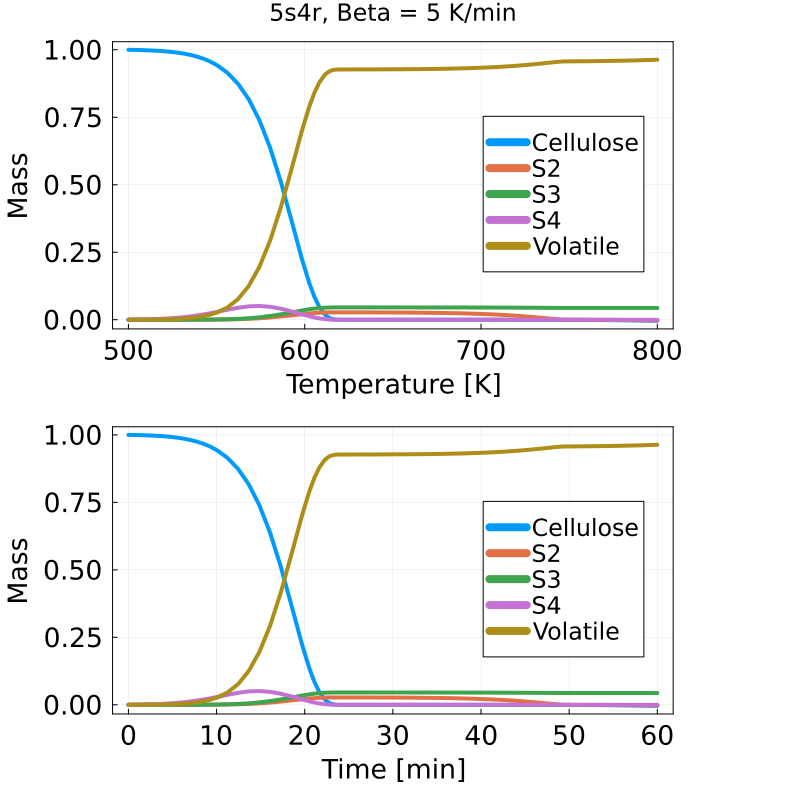

In [165]:
# Temperature values
T_values = T0 .+ beta * sol.t/60.0

theme(:default, titlefont = 16, guidefont = 18, tickfont = 18, legendfont = 16)

# Plot 1: Temperature vs Concentration (with Temperature on x-axis)
p1 = plot(T_values, 
          [[u[i] for u in sol.u] for i in 1:ns], 
          title = "5s4r, Beta = 5 K/min", 
          xlabel = "Temperature [K]", 
          ylabel = "Mass", 
          #label = ["Cellu" "S2" "S3" "Vola"],
          label = ["Cellulose" "S2" "S3" "S4" "Volatile"],
          lw = 4,
          legend = (0.75, 0.65))

# Plot 2: Concentration vs Time (in minutes)
p2 = plot(sol.t/60.0, 
          [[u[i] for u in sol.u] for i in 1:ns], 
          xlabel = "Time [min]", 
          ylabel = "Mass", 
          #label = ["Cellu" "S2" "S3" "Vola"],
          label = ["Cellulose" "S2" "S3" "S4" "Volatile"],
          lw  =4,
          legend = (0.75,0.65))

# Combine the two plots side by side
plt = plot(p1, p2, layout = (2, 1), framestyle = :box, size = (800, 800), right_margin = 30mm)
png(plt, string("5s4r(b)_odesolve_test_fig"))
plt